# Type coupling analysis and model training for deconvoluted Visium

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import ncem as nc
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import squidpy as sq
import pandas as pd

sc.settings.set_figure_params(dpi=80)

import warnings
warnings.filterwarnings("ignore")

Please ensure you have `ncem>=0.1.4` installed for running this tutorial. 

In [2]:
print(f"ncem=={nc.__version__}")

ncem==0.1.4


## ncem model and custom loader for deconvolution

In [3]:
from ncem.interpretation import InterpreterDeconvolution
from ncem.train import TrainModelLinearDeconvolution
from ncem.data import get_data_custom, customLoaderDeconvolution

## path to "pseudo" single-cell resolved anndata

The folder should contain an AnnData object that was deconvoluted with cell2location and save as "pseudo" single-cell file.

In [4]:
# path
datadir = '/lustre/groups/ml01/workspace/anna.schaar/ncem/data/cell2location_hvg/'

Reading the anndata object.

In [5]:
adata = sc.read(datadir + 'cell2location_lymphnode.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 64560 × 2000
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'node_type_names'
    obsm: 'node_types', 'proportions', 'spatial'

The anndata object must contain the following objects in `.obsm`: `node_types`, `proportions` and `spatial`. The example does not contain image or patient information, we will artifically add an image covariate to this dataset and showcase how to call the `customLoaderDeconvolution` with an `library_id` passed.

In [7]:
random_library_id = np.random.randint(2, size=adata.shape[0])
adata.obs['library_id'] = pd.Categorical([f"image_{i}" for i in random_library_id])

## Initialize ncem model for deconvoluted Visium

In [8]:
ncem_ip = InterpreterDeconvolution()

Link ncem to Anndata obect with library_id. We can set `radius=None` as the ncem model for deconvoluted Visium will aggregate interactions only within spots so we do not need to pass an specific radius. 

In [9]:
ncem_ip.data = customLoaderDeconvolution(
    adata=adata, patient=None, library_id='library_id', radius=None
)

Loading data from raw files
registering celldata
collecting image-wise celldata
adding graph-level covariates


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.57it/s]

Loaded 2 images with complete data from 1 patients over 64560 cells with 2000 cell features and 16 distinct celltypes.


In [10]:
get_data_custom(interpreter=ncem_ip, deconvolution=True)

Mean of mean node degree per images across images: 6.000000
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 64560 cells out of 2 images from 1 patients.
Test dataset: 6456 cells out of 2 images from 1 patients.
Training dataset: 52583 cells out of 2 images from 1 patients.
Validation dataset: 5811 cells out of 2 images from 1 patients. 



In [11]:
ncem_ip.get_sender_receiver_effects()

using ols parameters.
calculating inv fim.


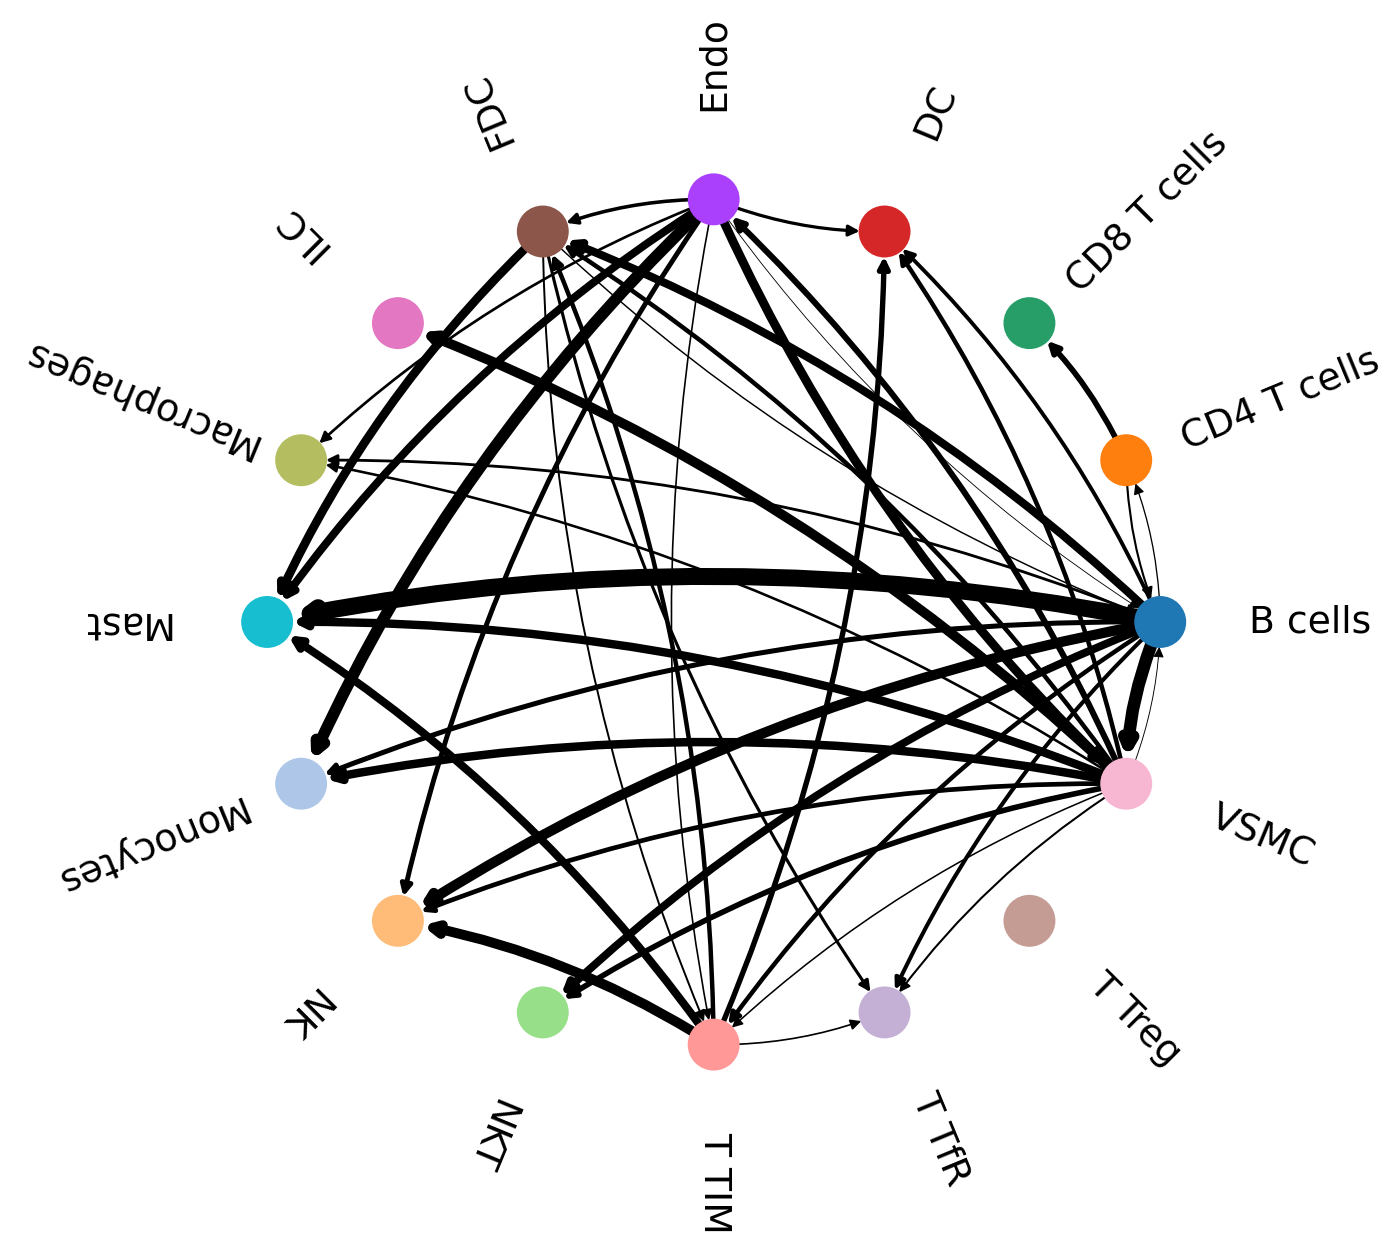

In [12]:
type_coupling = ncem_ip.type_coupling_analysis_circular(
    edge_attr='magnitude', figsize=(9,8), text_space=1.28, de_genes_threshold=150
)

## Training the ncem model for deconvoluted Visium

Initializing the linear ncem for deconvoluted data.

In [16]:
trainer = TrainModelLinearDeconvolution()
trainer.init_estim(log_transform=False)

Linking the estimator to the custom data object based on the "pseudo" single-cell adata object.

In [18]:
trainer.estimator.data = customLoaderDeconvolution(
    adata=adata, patient=None, library_id='library_id', radius=None
)
get_data_custom(interpreter=trainer.estimator, deconvolution=True)

Loading data from raw files
registering celldata
collecting image-wise celldata
adding graph-level covariates


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.58it/s]


Loaded 2 images with complete data from 1 patients over 64560 cells with 2000 cell features and 16 distinct celltypes.
Mean of mean node degree per images across images: 6.000000
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 64560 cells out of 2 images from 1 patients.
Test dataset: 6456 cells out of 2 images from 1 patients.
Training dataset: 52583 cells out of 2 images from 1 patients.
Validation dataset: 5811 cells out of 2 images from 1 patients. 



Initializing the model and displaying the model summary.

In [19]:
trainer.estimator.init_model(n_eval_nodes_per_graph=10)
trainer.estimator.model.training_model.summary()

Model: "interaction_linear_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 interaction (InputLayer)       [(None, 10, 256)]    0           []                               
                                                                                                  
 target (InputLayer)            [(None, 10, 16)]     0           []                               
                                                                                                  
 denseinteraction (DenseInterac  (None, 10, 256)     0           ['interaction[0][0]']            
 tions)                                                                                           
                                                                                                  
 categorical_predictor (InputLa  [(None, 10, 0)]     0           []        

Start training. Ideally, these steps are executed on a compute cluster. 

In [20]:
trainer.estimator.train(epochs=5)

16
16
Epoch 1/5
1/1 - 17s - loss: 1968.9088 - custom_mae: 0.2513 - custom_mean_sd: 1.0000 - custom_mse: 0.1310 - custom_mse_scaled: 0.1310 - gaussian_reconstruction_loss: 1968.9088 - r_squared: -2.1213e+00 - r_squared_linreg: 1.6621e-05 - val_loss: 1981.7584 - val_custom_mae: 0.2588 - val_custom_mean_sd: 0.9999 - val_custom_mse: 0.1441 - val_custom_mse_scaled: 0.1441 - val_gaussian_reconstruction_loss: 1981.7584 - val_r_squared: -1.5398e+00 - val_r_squared_linreg: 1.7011e-05 - lr: 1.0000e-04 - 17s/epoch - 17s/step
Epoch 2/5
1/1 - 9s - loss: 1958.0156 - custom_mae: 0.2401 - custom_mean_sd: 0.9999 - custom_mse: 0.1203 - custom_mse_scaled: 0.1203 - gaussian_reconstruction_loss: 1958.0156 - r_squared: -1.9895e+00 - r_squared_linreg: 1.0511e-05 - val_loss: 1968.4094 - val_custom_mae: 0.2449 - val_custom_mean_sd: 0.9998 - val_custom_mse: 0.1309 - val_custom_mse_scaled: 0.1309 - val_gaussian_reconstruction_loss: 1968.4094 - val_r_squared: -1.4331e+00 - val_r_squared_linreg: 2.2621e-07 - lr: 1